In [1]:
import sys
import time
sys.path.append('/home/kevinteng/Desktop/BrainTumourSegmentation')
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
import os, random
import utils
from utils_vis import plot_comparison, plot_labels_color, plot_loss
from utils import compute_metric_dc, data_aug
import nibabel as nib
from sklearn.model_selection import KFold
from loss_fn import *
%matplotlib inline

- Blue => Label 1 (Necrotic and Non-enhancing Tumor Core)
- Yellow => Label 2 (Peritumoral Edema)
- Green => Label 3/4 (GD-Enhancing Tumor)
---
* Core => Label 1 & 3
* Enhancing => Label 3
* Complete => Label 1,2, 3

---

# Hyperparameter

In [2]:
SHUFFLE_BUFFER = 4000
BATCH_SIZE = 8
lr = 0.00001
opt = tf.keras.optimizers.Adam(lr)
ver = 'model_vnet04' #save version
dropout=0.2 #dropout rate
hn = 'he_normal' #kernel initializer

---

# Helper Functions

---

----

# Model

In [3]:
from tensorflow.keras.layers import Conv3D, UpSampling3D, MaxPool3D, GaussianNoise
from tensorflow.keras.layers import Input, BatchNormalization, PReLU, ReLU, Dropout
from tensorflow.keras.layers import Add, Multiply, Activation
from tensorflow_addons.layers import GroupNormalization
from tensorflow.keras import Model

hn = 'he_normal' #kernel initializer

def conv_block_3D(x, filters, norm_fn='gn', kernel_size=3,
               kernel_initializer=hn, acti_fn='prelu', dropout_rate=None):
    '''
    Dual convolution block with [full pre-activation], Norm -> Acti -> Conv
    :param x: Input features
    :param filters: A list that contains the number of filters for 1st and 2nd convolutional layer
    :param norm_fn: Tensorflow function for normalization, 'bn' for Batch Norm, 'gn' for Group Norm
    :param kernel_size: Kernel size for both convolutional layer with 3x3 as default
    :param kernel_initializer: Initializer for kernel weights with 'glorot uniform' as default
    :param acti_fn: Tensorflow function for activation, 'relu' for ReLU, 'prelu' for PReLU
    :param dropout_rate: Specify dropouts for layers
    :return: Feature maps of same size as input with number of filters equivalent to the last layer
    '''
    assert type(filters)==list, "Please input filters of type list."
    assert acti_fn!= None, 'There should be an activation function specified'
    #1st convolutional block
    if norm_fn=='bn':
        x = BatchNormalization()(x)
    elif norm_fn=='gn':
        x = GroupNormalization()(x)
    if acti_fn=='relu':
        x = ReLU()(x)
    elif acti_fn=='prelu':
        x = PReLU(shared_axes=[1,2,3])(x)
    if dropout_rate != None:
        x = Dropout(dropout_rate)(x)
    x = Conv3D(filters[0], kernel_size, padding='same', kernel_initializer=kernel_initializer)(x)
    #2nd convolutional block
    if norm_fn=='bn':
        x = BatchNormalization()(x)
    elif norm_fn=='gn':
        x = GroupNormalization()(x)
    if acti_fn=='relu':
        x = ReLU()(x)
    elif acti_fn=='prelu':
        x = PReLU(shared_axes=[1,2,3])(x)
    x = Conv3D(filters[1], kernel_size, padding='same', kernel_initializer=kernel_initializer)(x)
    return x


def down_sampling_3D(x, filters, norm_fn='gn', kernel_size=3, acti_fn='relu',
            kernel_initializer=hn, dropout_rate=None):
    '''
    Down sampling function version 2 with Convolutional layer of stride 2 as downsampling operation, with
    [full pre-activation], Norm -> Acti -> Conv
    :param x: Input features
    :param filters: Number of filters for Convolutional layer of stride 2
    :param norm_fn: Tensorflow function for normalization, 'bn' for Batch Norm, 'gn' for Group Norm
    :param kernel_size: Kernel size for both convolutional layer with 3x3 as default
    :param acti_fn: Tensorflow function for activation, 'relu' for ReLU, 'prelu' for PReLU
    :param kernel_initializer: Initializer for kernel weights with 'glorot uniform' as default
    :param dropout_rate: Specify dropouts for layers
    :return: Feature maps of size scaled down by 2 with number of filters specified
    '''
    assert acti_fn!= None, 'There should be an activation function specified'
    #normalization
    if norm_fn=='bn':
        x = BatchNormalization()(x)
    elif norm_fn=='gn':
        x = GroupNormalization()(x)
    if acti_fn=='relu':
        x = ReLU()(x)
    #activation
    elif acti_fn=='prelu':
        x = PReLU(shared_axes=[1,2,3])(x)
    if dropout_rate != None:
        x = Dropout(dropout_rate)(x)
    #normal mode
    x = Conv3D(filters, kernel_size, strides=(2,2,2), padding='same', kernel_initializer=kernel_initializer)(x)
    return x


def res_block_3D(x_in, filters, norm_fn='gn', kernel_size=3,
               kernel_initializer=hn, acti_fn='prelu', dropout_rate=None):
    '''
    This function construct the residual block in 3D by input->conv_block_3D->concat([input,conv_output])
    :param x: Input features
    :param filters: A list that contains the number of filters for 1st and 2nd convolutional layer
    :param norm_fn: Tensorflow function for normalization, 'bn' for Batch Norm, 'gn' for Group Norm
    :param kernel_size: Kernel size for both convolutional layer with 3x3 as default
    :param kernel_initializer: Initializer for kernel weights with 'glorot uniform' as default
    :param acti_fn: Tensorflow function for activation, 'relu' for ReLU, 'prelu' for PReLU
    :param dropout_rate: Specify dropouts for layers
    :return: Resblock output => concatenating input with 2*convlutional output
    '''
    assert len(filters)==2, "Please assure that there is 2 values for filters."
    output_conv_block = conv_block_3D(x_in, filters, norm_fn=norm_fn, kernel_size=kernel_size,
                                   kernel_initializer = kernel_initializer, acti_fn = acti_fn, dropout_rate=dropout_rate)
    output_add = Add()([output_conv_block, x_in])
    return output_add


def up_3D(x_in, filters, merge, kernel_initializer=hn, size=(2, 2, 2)):
    '''
    This function carry out the operation of deconvolution => upsampling + convolution, and
    concatenating feture maps from the skip connection with the deconv feature maps
    @param x_in: input feature
    @param filters: Number of filters
    @param merge: featrure maps from the skip connection
    @param kernel_initializer: Initializer for kernel weights with 'glorot uniform' as default
    @param size: Upsampling size, by default (1,2,2)
    @return: concatenate feature maps of skip connection output and upsampled feature maps from previous output
    '''
    u = UpSampling3D(size)(x_in)
    conv = Conv3D(filters=filters, kernel_size=3, padding='same',
                  kernel_initializer=kernel_initializer)(u)
    conv = PReLU(shared_axes=[1,2,3])(conv)
    concat = tf.concat([merge, conv], axis=-1)
    return concat


def attention_block_3D(input_signal, gated_signal, filters, kernel_initializer=hn):
    # input signal feature maps
    is_fm = Conv3D(filters, kernel_size=1, strides=2, padding = 'same',
                   kernel_initializer=kernel_initializer)(input_signal)
    # gated signal feature maps
    gs_fm = Conv3D(filters, kernel_size=1, strides=1, padding = 'same',
                   kernel_initializer=kernel_initializer)(gated_signal)
    # debugger
    assert is_fm.shape!=gs_fm.shape, "Feature maps shape doesn't match!"
    # element wise sum
    add = Add()([is_fm, gs_fm])
    acti = Activation('relu')(add)
    # downsampled attention coefficient
    bottle_neck = Conv3D(1, kernel_size=1, activation='sigmoid',
                         kernel_initializer=kernel_initializer)(acti)
    # bilinear interpolation to get attention coeffcient
    alpha = UpSampling3D(size=2)(bottle_neck)
    # filter off input signal's features with attention coefficient
    multi = Multiply()([input_signal, alpha])
    return multi


def DeepAttVnet(x):
    #filter list depth of 4
    f_list = [8, 16, 32, 64, 128]
    # inject gaussian noise
    gauss1 = GaussianNoise(0.01)(x)
    # -----------down sampling path--------------------------------------
    # 1st block [128, 160, 160, 4]
    conv_01 = Conv3D(f_list[0], 3, padding='same', kernel_initializer=hn)(gauss1)
    conv_01 = PReLU(shared_axes=[1,2,3])(conv_01)
    res_block01 = conv_block_3D(conv_01, filters=[f_list[0], f_list[0]])
    # 2nd block [64, 80, 80, 4]
    down_01 = down_sampling_3D(res_block01,filters=f_list[1])
    res_block02 = res_block_3D(down_01, filters=[f_list[1], f_list[1]])
    # 3rd block [32, 40, 40, 4]
    down_02 = down_sampling_3D(res_block02,filters=f_list[2])
    res_block03 = res_block_3D(down_02, filters=[f_list[2], f_list[2]])
    # 4th block [16, 20, 20, 4]
    down_03 = down_sampling_3D(res_block03,filters=f_list[3])
    res_block04 = res_block_3D(down_03, filters=[f_list[3], f_list[3]])
    # 5th block [8, 10, 10, 4]
    down_04 = down_sampling_3D(res_block04,filters=f_list[4])
    res_block05 = res_block_3D(down_04, filters=[f_list[4], f_list[4]])

    # -----------up sampling path-----------------------------------------
    # 1st attention block---
    att_01 = attention_block_3D(res_block04, res_block05, f_list[3])
    # 1st up [16, 20, 20, 4]
    up_01 = up_3D(res_block05, f_list[3], att_01)
    up_conv01 = conv_block_3D(up_01, filters=[f_list[3], f_list[3]])

    # 2nd attention block---
    att_02 = attention_block_3D(res_block03, up_conv01, f_list[2])
    # 2nd up [32, 40, 40, 4]
    up_02 = up_3D(up_conv01, f_list[2], att_02)
    up_conv02 = conv_block_3D(up_02, filters=[f_list[2], f_list[2]])
    # 2nd block segmentation output
    seg_02 = Conv3D(4, kernel_size=1, padding='same', kernel_initializer=hn)(up_conv02)

    # 3rd attention block---
    att_03 = attention_block_3D(res_block02, up_conv02, f_list[1])
    # 3rd up [64, 80, 80, 4]
    up_03 = up_3D(up_conv02, f_list[1], att_03)
    up_conv03 = conv_block_3D(up_03, filters=[f_list[1], f_list[1]])
    # 3rd block segmentation output
    seg_03 = Conv3D(4, kernel_size=1, padding='same', kernel_initializer=hn)(up_conv03)

    # 4th attention block---
    att_04 = attention_block_3D(res_block01, up_conv03, f_list[0])
    # 4th up [128, 160, 160, 4]
    up_04 = up_3D(up_conv03, f_list[1], att_04)
    up_conv04 = conv_block_3D(up_04, filters=[f_list[0], f_list[0]])
    # 4th block segmentation output
    seg_04 = Conv3D(4, kernel_size=1, padding='same', kernel_initializer=hn)(up_conv04)

    # Deep Supervision---
    #Add all segmentation output before inputting into the output layer
    #upsample to fit the size of seg_03
    seg_02_up = UpSampling3D(size=2)(seg_02)
    add_0203 = Add()([seg_02_up,seg_03])
    #upsample to fit the size of seg_03
    add_0203_up = UpSampling3D(size=2)(add_0203)
    add_020304 = Add()([add_0203_up, seg_04])

    #segmentation output
    output = Conv3D(4,kernel_size=1, activation='softmax',
                    kernel_initializer=hn)(add_020304)
    return output

In [4]:
#Build Model
input_layer = Input(shape=(128,160,160,4))
model = Model(input_layer, DeepAttVnet(input_layer))

In [5]:
xent = tf.keras.losses.CategoricalCrossentropy()

@tf.function
def train_fn(image, label):
    with tf.GradientTape() as tape:
        model_output = model(image, training=True)
        loss, l_xent, l_dc  = custom_loss(label, model_output)
        l_list = [loss, l_xent, l_dc]
    gradients = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))

    return model_output, l_list, gradients

---


Epochs  1



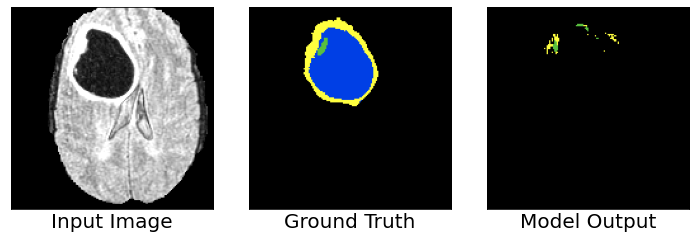

Steps: 300, L_xent: 0.4303513765335083, L_dc: 0.6385100483894348
Total loss: 1.068861484527588
Accurary: 0.8866797089576721
Seq: TC, ET, WT
Dice coefficient: [0.7559201389085501, 0.8805902778171003, 0.702282395058622]
Gradient min:-1.17264986038208, max:0.5479322075843811
Compute time per epochs: 12.55 mins

Epochs  2



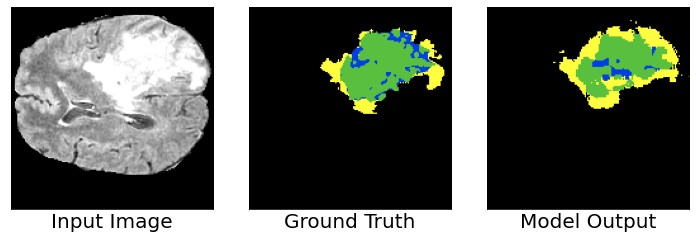

Steps: 300, L_xent: 0.10242249816656113, L_dc: 0.6053329706192017
Total loss: 0.707755446434021
Accurary: 0.9378515481948853
Seq: TC, ET, WT
Dice coefficient: [0.8052992846583947, 0.8966629937756807, 0.7846445613075048]
Gradient min:-0.1020461842417717, max:0.05756746232509613
Compute time per epochs: 12.27 mins

Epochs  3



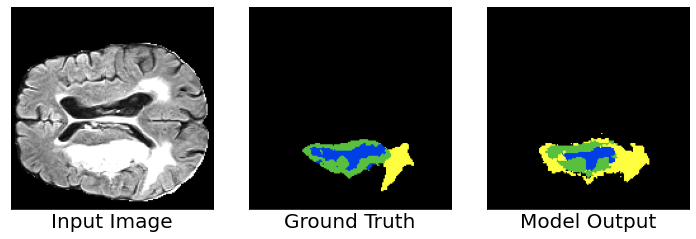

Steps: 300, L_xent: 0.07067622989416122, L_dc: 0.5583299398422241
Total loss: 0.6290061473846436
Accurary: 0.9620312452316284
Seq: TC, ET, WT
Dice coefficient: [0.9320909863803536, 0.9286227450706065, 0.8968840580744047]
Gradient min:-0.5637152791023254, max:0.2422882318496704
Compute time per epochs: 12.25 mins

Epochs  4



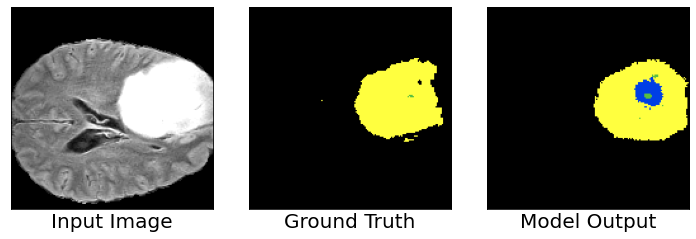

Steps: 300, L_xent: 0.09083390980958939, L_dc: 0.7562568783760071
Total loss: 0.8470907807350159
Accurary: 0.9571093916893005
Seq: TC, ET, WT
Dice coefficient: [0.8952083334326744, 0.9529166668653488, 0.900069692125544]
Gradient min:-0.20084333419799805, max:0.3290248215198517
Compute time per epochs: 12.27 mins

Epochs  5



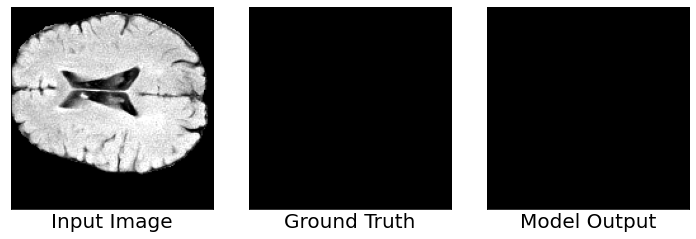

Steps: 300, L_xent: 0.011340860277414322, L_dc: 0.6361681222915649
Total loss: 0.647508978843689
Accurary: 1.0
Seq: TC, ET, WT
Dice coefficient: [1.0, 1.0, 1.0]
Gradient min:-0.2947501540184021, max:0.12818852066993713
Compute time per epochs: 13.01 mins

Epochs  6



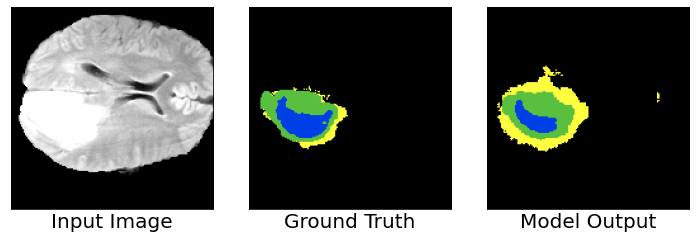

Steps: 300, L_xent: 0.06667619943618774, L_dc: 0.5125631093978882
Total loss: 0.5792393088340759
Accurary: 0.9454296827316284
Seq: TC, ET, WT
Dice coefficient: [0.9136383379576728, 0.9070471653249115, 0.8431153071268151]
Gradient min:-0.20987820625305176, max:0.20626632869243622
Compute time per epochs: 12.30 mins

Epochs  7



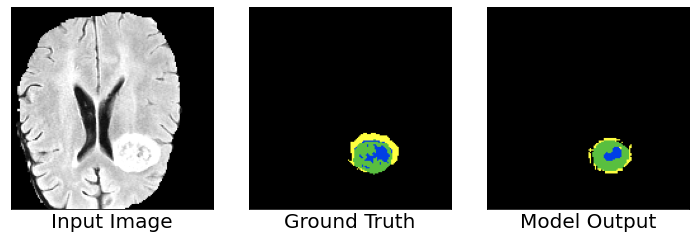

Steps: 300, L_xent: 0.06376321613788605, L_dc: 0.3691111207008362
Total loss: 0.43287432193756104
Accurary: 0.9821484088897705
Seq: TC, ET, WT
Dice coefficient: [0.9273500083014369, 0.9405549917370081, 0.9004649946155647]
Gradient min:-0.2011239379644394, max:0.10812170803546906
Compute time per epochs: 12.30 mins

Epochs  8



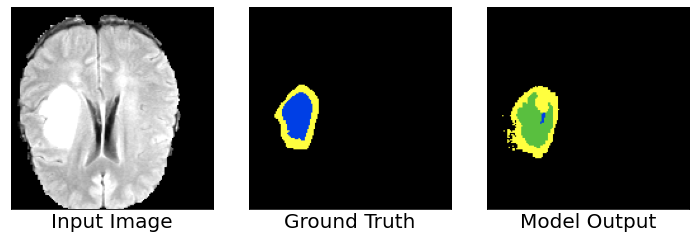

Steps: 300, L_xent: 0.07966482639312744, L_dc: 0.9909931421279907
Total loss: 1.0706579685211182
Accurary: 0.9504296779632568
Seq: TC, ET, WT
Dice coefficient: [0.7492666301550344, 0.725, 0.7627851775071274]
Gradient min:-0.2697995603084564, max:0.1792829930782318
Compute time per epochs: 12.31 mins

Epochs  9



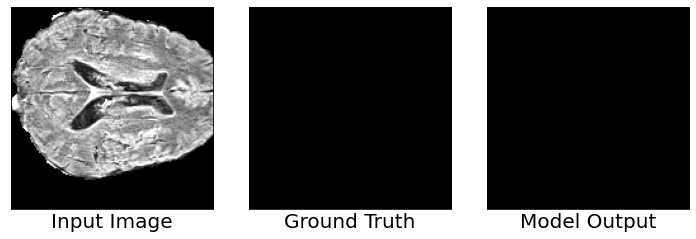

Steps: 300, L_xent: 0.014458419755101204, L_dc: 0.4768816828727722
Total loss: 0.49134010076522827
Accurary: 1.0
Seq: TC, ET, WT
Dice coefficient: [1.0, 1.0, 1.0]
Gradient min:-0.05755828693509102, max:0.21831631660461426
Compute time per epochs: 12.31 mins

Epochs 10



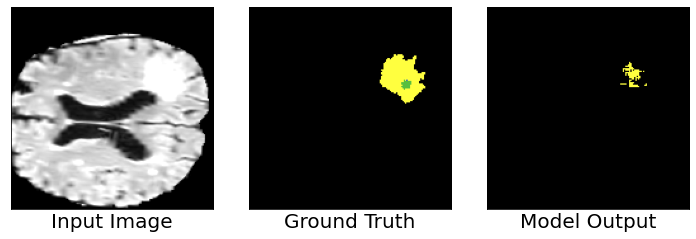

Steps: 300, L_xent: 0.019354602321982384, L_dc: 0.6604028940200806
Total loss: 0.6797574758529663
Accurary: 0.9703906178474426
Seq: TC, ET, WT
Dice coefficient: [0.971875, 0.95, 0.9144255424073587]
Gradient min:-0.748485267162323, max:0.616059422492981
Compute time per epochs: 13.02 mins

----------------------------------<END>---------------------------------
Total run time for 10 epochs: 124.59 mins


In [6]:
#numpy dir
npy_dir = '/home/kevinteng/Desktop/ssd02/BraTS2020_preprocessed05/Training_pre/'
#
pre_epochs = 40
max_epochs = 50
#remainder epochs 
re_epochs = max_epochs - pre_epochs 
if pre_epochs!=0:
    model.load_weights('/home/kevinteng/Desktop/model_weights/model_{}.h5'.format(ver))
    upp_bound = re_epochs
else:
    upp_bound = max_epochs
    
epochs = 1
#list
loss_list = []
start_runtime = time.time()
while epochs <= upp_bound:
    start = time.time()
    print()
    print("Epochs {:2d}".format(epochs))
    steps = 1
    ds = os.listdir(npy_dir)
    #shuffle directory list of .npy
    shuffle = random.shuffle(ds)
    loss_inner = []
    for npy in ds:
        npy_path = os.path.join(npy_dir+npy)
        #load npy file => [155, 240, 240, 4]
        imgs = np.load(npy_path)
        #trim images [155,240,240,4] => [128,160,160,4]
        imgs = imgs[15:143,50:210,50:210,:]
        #data augmentation
        imgs = data_aug(imgs)
        #expand and slice dimes => [1,128,160,160,4]
        imgs = tf.expand_dims(imgs, axis=0)
        #image indices 
        image = imgs[...,:4]
        #unprocessed label for plotting (cropped)
        label = imgs[...,-1]
        #for simplicity label 4 will be converted to 3 for sparse encoding
        label = tf.where(label==4,3,label)
        label = tf.keras.utils.to_categorical(label, num_classes=4)
        #--------------<training function>----------------------------
        img_seg, l_list, gradients = train_fn(image, label)
        #map from sparse to label
        img_seg = tf.math.argmax(img_seg,-1,output_type=tf.int32)
        label = tf.math.argmax(label,-1,output_type=tf.int32)
        #accuracy of the output values for that batch
        acc = tf.reduce_mean(tf.cast(tf.equal(img_seg,label), tf.float32))
        #store loss total for every steps
        loss_inner.append(l_list[0].numpy())
        #save weights for every 5 epochs
        if epochs%5==0:
            model.save_weights('/home/kevinteng/Desktop/model_weights/model_{}.h5'.format(ver))
        #output
        slice = 70
        if steps%300==0:
            input_img = [image[0,slice,...,0], plot_labels_color(label[0,slice]), plot_labels_color(img_seg[0, slice])]
            caption = ['Input Image', 'Ground Truth', 'Model Output']
            plot_comparison(input_img, caption, n_col = 3, figsize=(10,10))
            acc_stp = tf.reduce_mean(tf.cast(tf.equal(img_seg[0,slice],label[0,slice]), tf.float32))
            dc_list_stp =compute_metric_dc(label[0,slice],img_seg[0,slice])
            print("Steps: {}, L_xent: {}, L_dc: {}".format(steps, l_list[1].numpy(), l_list[-1].numpy()))
            print("Total loss: {}".format(l_list[0]))
            print("Accurary: {}".format(acc_stp))
            print("Seq: TC, ET, WT")
            print("Dice coefficient: {}".format(dc_list_stp))
            print("Gradient min:{}, max:{}".format(np.min(gradients[0]), np.max(gradients[0])))
        steps+=1
    loss_list.append(np.mean(loss_inner))
    #end time per epochs 
    elapsed_time =(time.time()-start)/60 #unit in mins
    print("Compute time per epochs: {:.2f} mins".format(elapsed_time))
    epochs+=1
#end time for total epochs
elapsed_time_runtime = (time.time()-start_runtime)/60
print()
print('----------------------------------<END>---------------------------------')
print("Total run time for {} epochs: {:.2f} mins".format(epochs-1, elapsed_time_runtime))

---

# Save Weights

In [8]:
model.save_weights('/home/kevinteng/Desktop/model_weights/model_{}.h5'.format(ver))

---

# Validation 

In [9]:
model.load_weights('/home/kevinteng/Desktop/model_weights/model_{}.h5'.format(ver))
def output_fn(image):
    model.trainable = False
    model_output = model(image)
    # we need [240,240,155] to input into cloud validation
    padding = tf.constant([[0,0],[15,12],[50,30],[50,30],[0,0]])
    model_output = tf.pad(model_output, padding, "CONSTANT")
    return model_output

In [10]:
ds = '/home/kevinteng/Desktop/ssd02/BraTS2020_preprocessed05/'
save_path = '/home/kevinteng/Desktop/ssd02/submission/'
actual_label = '/home/kevinteng/Desktop/ssd02/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii.gz'
#all brain affine are the same just pick one 
brain_affine = nib.load(actual_label).affine
for train_or_val in sorted(os.listdir(ds)):
    save_dir = save_path + train_or_val+'_'+ver
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    merge01 = os.path.join(ds+train_or_val)
    for patient in sorted(os.listdir(merge01)):
        patient_id = patient.split('.')[0]
        merge02 = os.path.join(merge01,patient)
        imgs = np.load(merge02)
        #expand and slice dimes => [1,128,160,160,4]
        inp = tf.expand_dims(imgs[15:143,50:210,50:210,:4], axis=0)
        img_seg = output_fn(inp) #validation function
        #output dim => [1,155,240,240,4]
        #map from sparse to label
        seg_output = tf.squeeze(np.argmax(img_seg,-1))
        #swap axis for validation: [155,240,240]->[240,240,155]
        seg_output = np.swapaxes(seg_output, 0,1)
        seg_output = np.swapaxes(seg_output, 1,2)
        #convert label from 4 to 3 and np array and cast as int
        seg_output= np.where(seg_output==3,4,seg_output).astype(np.uint8)
        prediction_ni = nib.Nifti1Image(seg_output, brain_affine)
        prediction_ni.to_filename(save_dir+'/{}.nii.gz'.format(patient_id))

In [ ]:
img_path = '/home/kevinteng/Desktop/ssd02/submission/Validation_pre_model_vnet01/BraTS20_Validation_001.nii.gz'
img_affine = nib.load(img_path).affine
img = nib.load(img_path)
print(img.shape)

---

# Model Summary

In [ ]:
model.summary()